

# Ephaptic Coupling #

### Import stuff

In [1]:
%pylab inline

import numpy as np
import sys
if sys.version < '3':
    from urllib2 import urlopen
else:    
    from urllib.request import urlopen
import ssl
from warnings import warn
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import LFPy
import neuron
from neuron import h
from custom_plots import plot_cell
from create_generator import generator

Populating the interactive namespace from numpy and matplotlib


## Create receptor cell

In [2]:
cellParameters = {
        'morphology' : 'morphology/mitral/mitral.hoc',     # mitral neuron (olfactory)
    #     'morphology' : 'morphology/mitral.hoc',            # mitral neuron (olfactory)
    #     'morphology' : 'morphology/purkinje.hoc',          # purkinje neuron (cerebellum)
    #     'morphology' : 'morphology/pyramidal_layer2.hoc',  # pyramidal neuron (cortex)
    #     'morphology' : 'morphology/pyramidal_layer5.hoc',  # pyramidal neuron (cortex)
    #     'morphology' : 'morphology/aspiny_layer3.hoc',     # aspiny neuron (cortex)
    #     'morphology' : 'morphology/stellate_layer4.hoc' ,   # stellate neuron (cortex)
        'cm' : 1.0,                 # membrane capacitance
        'Ra' : 150.,                # axial resistance
        'passive' : True,           # turn on NEURONs passive mechanism for all sections
        'nsegs_method' : None,      # spatial discretization method
        'dt' : 2**-6,               # simulation time step size
        'tstart' : 0,               # start time of simulation
        'tstop' : 40,               # stop simulation
        'v_init' : -60,             # initial crossmembrane potential
        'celsius': 34,
        'pt3d' : True,
        'extracellular': True,
        'passive_parameters' : {'g_pas' : 1./30000, 'e_pas' : -60},
    }
    

In [3]:
#Generating input from de cell1
spike_times1 = [1.]
xs1 = -200
ys1 = 0
zs1 = 0
sigma = 0.3

electrode1, synapse_i1, generator_cell_vmem1, generator_cell_soma1 = generator(spike_times1,xs1,ys1,zs1,sigma)

	1 


In [5]:
#Generating input from de cell2
spike_times2 = [20.,30]
xs2 = 200
ys2 = 0
zs2 = 0
sigma = 0.3

electrode2, synapse_i2, generator_cell_vmem2, generator_cell_soma2 = generator(spike_times2,xs2,ys2,zs2,sigma)


	1 
Overwriting custom temperature of 34.00. New temperature is 34.00


In [7]:
# initialize cell instance, using the LFPy.Cell class
receptor_cell = LFPy.Cell(**cellParameters)
receptor_cell.set_rotation(x=4.729, y=-3.166)
receptor_cell.xmid += 0         # added distance of the electrodes to the receptor cell in x plane

# time of extracellular field simulation
t = np.arange(electrode2.LFP.shape[1]) * receptor_cell.dt


electrode_sum = electrode1.LFP + electrode2.LFP

#receptor_cell.insert_v_ext(electrode1.LFP, t)

receptor_cell.insert_v_ext(electrode_sum, t)

# perform receptor cell simulation
receptor_cell.simulate(rec_vmem=True)


	1 
Overwriting custom temperature of 34.00. New temperature is 34.00


### Find index positions of electrodes in the receptor cell

Target index is: 259
Target position is: [-159.5422287   578.12954712]
-23.66789134680021


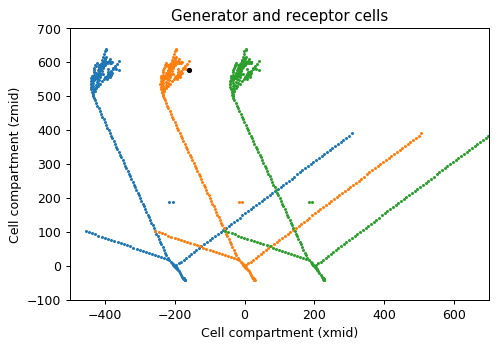

In [22]:
positions = np.array(list(zip(receptor_cell.xmid, receptor_cell.zmid)))  # array all cell positions
target_index = receptor_cell.get_closest_idx(x=0., y=0., z=600)         # find closest electrode to target position
target_pos = positions[target_index] 

print('Target index is:', target_index)
print('Target position is:', target_pos)

# plot generator and receptor compartments with target
plt.figure(figsize=(6,4), dpi=90)
plt.scatter(receptor_cell.xmid+xs1, receptor_cell.zmid + zs1 ,s=2)  # blue - generator1
plt.scatter(receptor_cell.xmid, receptor_cell.zmid ,s=2)    # orange
plt.scatter(receptor_cell.xmid+xs2, receptor_cell.zmid + zs2 ,s=2) # green - generator2
plt.scatter(target_pos[0],target_pos[1],s=10,color='k')     # black dot = target position 
plt.title('Generator and receptor cells')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')
plt.xlim([-500,700])
plt.ylim([-100,700])
print(receptor_cell.xmid[1])  ### pq não mudou???

### Plot Vmem in receptor cell over time

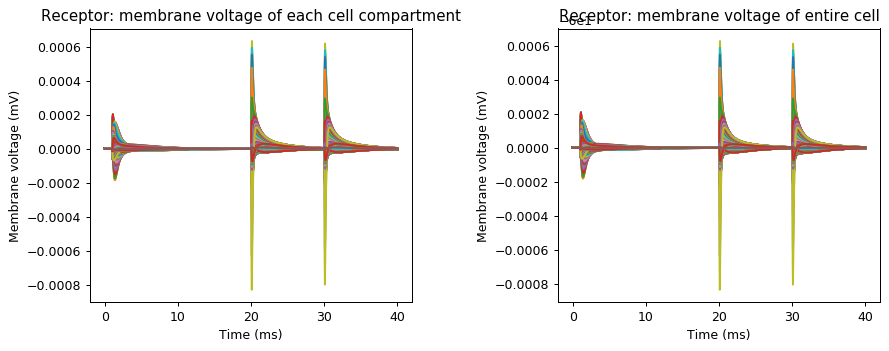

In [23]:
plt.figure(figsize=(10,4), dpi=90)

# plot vmem in each receptor cell compartment over time
plt.subplot(121)
plt.plot(receptor_cell.tvec,receptor_cell.vmem.T - receptor_cell.vmem.mean(axis=0).reshape(-1,1));
plt.title('Receptor: membrane voltage of each cell compartment')
plt.ylabel('Membrane voltage (mV)')
plt.xlabel('Time (ms)')

# plot vmem of all receptor cell compartments over time
plt.subplot(122)
plt.plot(receptor_cell.tvec,receptor_cell.vmem.T);
plt.title('Receptor: membrane voltage of entire cell')
plt.ylabel('Membrane voltage (mV)')
plt.xlabel('Time (ms)')

plt.tight_layout()

Text(0, 0.5, 'Cell compartment (zmid)')

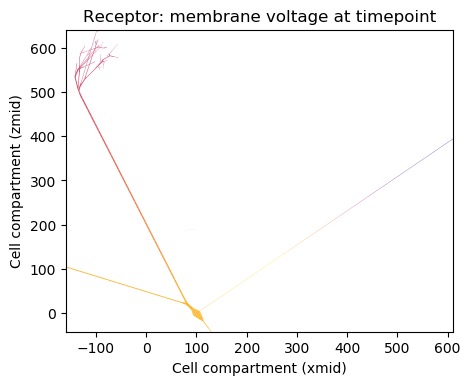

In [11]:
# plot receptor cell vmem with morphology
target_ms = 15      # time in ms
timepoint = int(target_ms/(2**-6))    # simulation time point
plt.figure(figsize=(5, 4), dpi=100)
plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,timepoint], palette='plasma')
plt.title('Receptor: membrane voltage at timepoint')
plt.xlabel('Cell compartment (xmid)')
plt.ylabel('Cell compartment (zmid)')

# # plot receptor cell vmem interactively over time
# def plot_time(t=100):
#     plot_cell(receptor_cell, x_off=100, voltage=receptor_cell.vmem[:,t], palette='plasma')
#     plt.title('Receptor: membrane voltage over time')
# wdg.interact(plot_time)

### Plot of ephaptic coupling between the cells: Vmem in SOMA

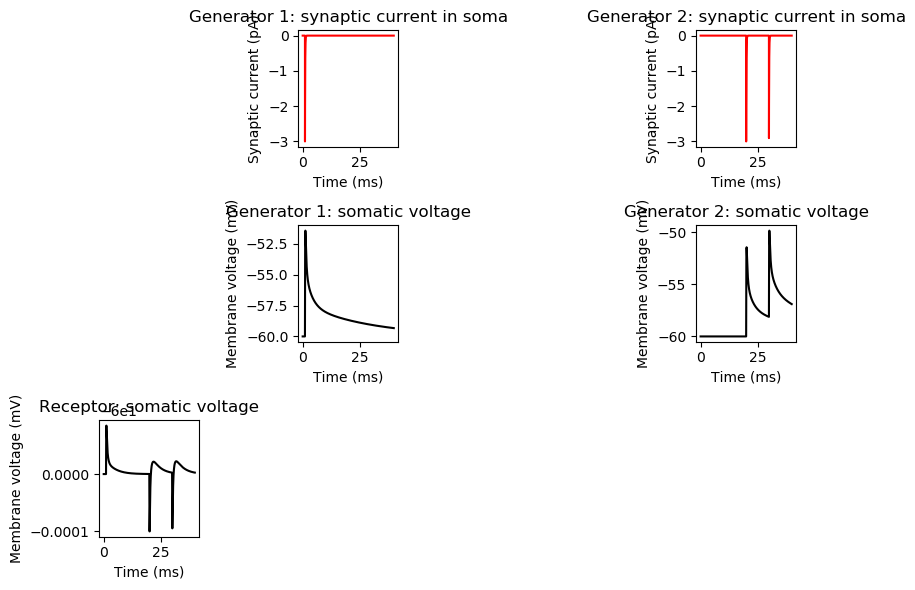

In [12]:
plt.figure(figsize=(9, 6), dpi=100)
plt.subplot(342)
plt.plot(receptor_cell.tvec, synapse_i1, 'r'), plt.title('Generator 1: synaptic current in soma')
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic current (pA)')


plt.subplot(344)
plt.plot(receptor_cell.tvec, synapse_i2, 'r'), plt.title('Generator 2: synaptic current in soma')
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic current (pA)')


plt.subplot(346)
plt.plot(receptor_cell.tvec, generator_cell_soma1, 'k'), plt.title('Generator 1: somatic voltage')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.subplot(348)
plt.plot(receptor_cell.tvec, generator_cell_soma2, 'k'), plt.title('Generator 2: somatic voltage')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.subplot(349)
plt.plot(receptor_cell.tvec, receptor_cell.somav, 'k'), plt.title('Receptor: somatic voltage')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')


plt.tight_layout()

### Plot of ephaptic coupling between cells: Vmem of the indexed position 

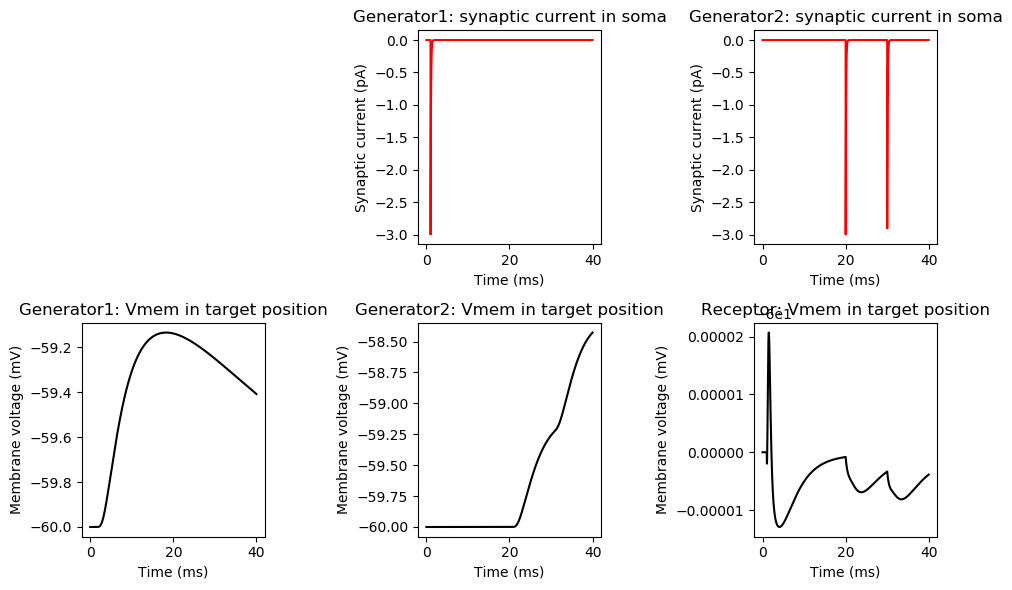

In [13]:
plt.figure(figsize=(10, 6), dpi=100)
plt.subplot(232)
plt.plot(receptor_cell.tvec, synapse_i1, 'r'), plt.title('Generator1: synaptic current in soma')
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic current (pA)')

plt.subplot(233)
plt.plot(receptor_cell.tvec, synapse_i2, 'r'), plt.title('Generator2: synaptic current in soma')
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic current (pA)')

plt.subplot(234)
plt.plot(receptor_cell.tvec, generator_cell_vmem1[target_index], 'k'), plt.title('Generator1: Vmem in target position')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')


plt.subplot(235)
plt.plot(receptor_cell.tvec, generator_cell_vmem2[target_index], 'k'), plt.title('Generator2: Vmem in target position')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.subplot(236)
plt.plot(receptor_cell.tvec, receptor_cell.vmem[target_index], 'k'), plt.title('Receptor: Vmem in target position')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane voltage (mV)')

plt.tight_layout()